# Prédiction du Churn Client - MLflow Organisé

## Du Chaos à la Reproductibilité

Dans le notebook précédent (`01_messy_notebook.ipynb`), nous avons vécu le chaos typique du data science :
- Plusieurs expériences sans tracking
- Métriques éparpillées dans les cellules
- "C'était lequel le meilleur modèle déjà ?"
- Pas de versioning ni de reproductibilité

**Dans ce notebook, nous résolvons ces problèmes avec MLflow :**
- Tracking d'expériences (paramètres, métriques, artefacts)
- Versioning de modèles et registry
- Comparaison facile entre les runs
- Résultats reproductibles

---

## 1. Setup et Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# NOUVEAU : imports MLflow
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

print(f"Version MLflow : {mlflow.__version__}")

Version MLflow : 3.9.0


## 2. Configuration MLflow

MLflow doit savoir :
1. **Où stocker les données de tracking** (tracking URI)
2. **Dans quelle expérience logger** (nom de l'expérience)

**Pour ce workshop :** Démarrez d'abord le serveur MLflow avec `docker-compose up -d`

> ⚠️ **Utilisateurs Mac** : Le port 5000 est utilisé par AirPlay Receiver sur macOS Monterey+.
> Si vous avez une erreur de connexion, modifiez `MLFLOW_PORT=5050` dans votre fichier `.env`
> et utilisez `http://localhost:5050` au lieu de `http://localhost:5000`.

In [4]:
# Configurer le tracking MLflow
# Se connecter au serveur MLflow hébergé dans Docker (démarrer avec : docker-compose up -d)
mlflow.set_tracking_uri("http://localhost:5000")

# Créer ou récupérer l'expérience
experiment_name = "customer-churn-prediction-correction"
mlflow.set_experiment(experiment_name)

print(f"Tracking URI : {mlflow.get_tracking_uri()}")
print(f"Expérience : {experiment_name}")

# Tester la connexion avec un simple ping
try:
    import requests
    response = requests.get(f"{mlflow.get_tracking_uri()}/health")
    print(f"✅ Serveur MLflow répond : {response.status_code}")
except Exception as e:
    print(f"❌ Impossible de se connecter au serveur MLflow : {e}")

Tracking URI : http://localhost:5000
Expérience : customer-churn-prediction-correction
✅ Serveur MLflow répond : 200


## 3. Charger les données

On charge les données clients depuis le CSV. Exécutez `python generate_sample_data.py` d'abord si le fichier n'existe pas.

In [5]:
# Charger les données clients depuis le CSV
df = pd.read_csv('../data/customer_data.csv')

print(f"Dimensions du dataset : {df.shape}")
print(f"Taux de churn : {df['churned'].mean():.2%}")
df.head()

Dimensions du dataset : (5000, 10)
Taux de churn : 49.04%


,customer_id,recency_days,frequency,monetary_value,avg_order_value,days_since_signup,total_orders,support_tickets,age,churned
0,1,156,9,6800.38,759.81,596,9,0,18,1
1,2,66,14,792.94,94.69,393,7,0,29,0
2,3,97,3,1005.08,285.39,367,3,0,37,1
3,4,1,11,2844.91,404.44,367,6,0,38,0
4,5,19,5,1749.75,136.75,1084,12,2,18,1


## 4. Feature Engineering

Mêmes features qu'avant - nous allons tracker quelles features nous utilisons dans MLflow.

In [6]:
def engineer_features(df):
    """Créer des features engineerées - encapsulé dans une fonction pour la reproductibilité"""
    df = df.copy()
    
    # Features de ratio
    df['recency_frequency_ratio'] = df['recency_days'] / (df['frequency'] + 1)
    df['monetary_per_order'] = df['monetary_value'] / (df['total_orders'] + 1)
    df['order_frequency'] = df['total_orders'] / (df['days_since_signup'] + 1)
    df['support_per_order'] = df['support_tickets'] / (df['total_orders'] + 1)
    
    # Score RFM
    df['r_score'] = pd.qcut(df['recency_days'], q=5, labels=[5, 4, 3, 2, 1]).astype(int)
    df['f_score'] = pd.qcut(df['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5]).astype(int)
    df['m_score'] = pd.qcut(df['monetary_value'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5]).astype(int)
    df['rfm_score'] = df['r_score'] + df['f_score'] + df['m_score']
    
    return df

# Appliquer le feature engineering
df = engineer_features(df)
print(f"Features après engineering : {df.shape[1]} colonnes")

Features après engineering : 18 colonnes


In [7]:
# Définir les colonnes de features (on va logger ça dans MLflow)
FEATURE_COLS = [
    'recency_days', 'frequency', 'monetary_value', 'avg_order_value',
    'days_since_signup', 'total_orders', 'support_tickets', 'age',
    'recency_frequency_ratio', 'monetary_per_order', 'order_frequency',
    'support_per_order', 'rfm_score'
]

X = df[FEATURE_COLS]
y = df['churned']

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Échantillons d'entraînement : {len(X_train)}")
print(f"Échantillons de test : {len(X_test)}")

Échantillons d'entraînement : 4000
Échantillons de test : 1000


## 5. Tracking d'expériences MLflow

Maintenant la magie opère ! Au lieu d'afficher les métriques et de les oublier, nous **loggons tout dans MLflow**.

### Concepts clés MLflow :
- **Run** : Une exécution unique de votre code (une expérience)
- **Parameters** : Les entrées de votre modèle (hyperparamètres)
- **Metrics** : Les sorties/résultats (accuracy, F1, etc.)
- **Artifacts** : Les fichiers (modèles, graphiques, échantillons de données)
- **Tags** : Les métadonnées (auteur, version, notes)

### 5.1 Exemple de logging manuel

**Ce qu'on logge :**
- **Parameters** : Hyperparamètres, nombre de features, tailles train/test
- **Metrics** : Accuracy, precision, recall, F1
- **Artifacts** : Modèle, matrice de confusion, importance des features
- **Evaluation Tables** : Tableau détaillé des prédictions
- **Dataset** : Info sur les données d'entraînement (comme autolog fait)

**Note :** Assurez-vous que l'autologging est désactivé avant le logging manuel pour éviter les conflits.

In [8]:
# S'assurer que l'autologging est désactivé pour éviter les conflits
mlflow.sklearn.autolog(disable=True)

import tempfile
import os

def train_and_log_model(model, model_name, X_train, X_test, y_train, y_test, params=None):
    """
    Entraîner un modèle et logger tout dans MLflow.
    Inclut : paramètres, métriques, modèle, artefacts, résultats d'évaluation et dataset.
    """
    with mlflow.start_run(run_name=model_name):
        # Logger les tags (métadonnées)
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("author", "workshop")
        mlflow.set_tag("stage", "experimentation")
        
        # === Logger le dataset (comme autolog fait) ===
        train_data = X_train.copy()
        train_data['target'] = y_train.values
        dataset = mlflow.data.from_pandas(
            train_data, 
            source="../data/customer_data.csv",
            name="customer_churn_training",
            targets="target"
        )
        mlflow.log_input(dataset, context="training")
        
        # Logger les paramètres
        if params:
            mlflow.log_params(params)
        mlflow.log_param("n_features", len(FEATURE_COLS))
        mlflow.log_param("train_size", len(X_train))
        mlflow.log_param("test_size", len(X_test))
        
        # Entraîner le modèle
        model.fit(X_train, y_train)
        
        # Faire des prédictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculer et logger les métriques
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        }
        mlflow.log_metrics(metrics)
        
        # Logger les résultats d'évaluation en CSV avec tempfile (pas de fichier local laissé)
        eval_df = pd.DataFrame({
            'actual': y_test.values,
            'predicted': y_pred,
            'probability': y_proba if y_proba is not None else [None] * len(y_pred),
            'correct': (y_test.values == y_pred).astype(int)
        })
        with tempfile.TemporaryDirectory() as tmpdir:
            csv_path = os.path.join(tmpdir, "evaluation_results.csv")
            eval_df.to_csv(csv_path, index=False)
            mlflow.log_artifact(csv_path)
        
        # Logger le modèle
        mlflow.sklearn.log_model(model, name="model")
        
        # Logger l'importance des features (si disponible) - avec log_figure (pas de fichier local)
        if hasattr(model, 'feature_importances_'):
            fig, ax = plt.subplots(figsize=(10, 6))
            feat_imp = pd.Series(model.feature_importances_, index=FEATURE_COLS)
            feat_imp.sort_values().plot(kind='barh', ax=ax)
            ax.set_title(f'Importance des Features - {model_name}')
            plt.tight_layout()
            mlflow.log_figure(fig, "feature_importance.png")
            plt.close()
        
        # Logger la matrice de confusion - avec log_figure (pas de fichier local)
        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Prédit')
        ax.set_ylabel('Réel')
        ax.set_title(f'Matrice de Confusion - {model_name}')
        plt.tight_layout()
        mlflow.log_figure(fig, "confusion_matrix.png")
        plt.close()
        
        run_id = mlflow.active_run().info.run_id
        print(f"Modèle : {model_name} | Accuracy : {metrics['accuracy']:.4f} | F1 : {metrics['f1']:.4f}")
        print(f"Loggé : modèle, dataset, matrice de confusion, CSV d'évaluation")
        
        return run_id, metrics

### 5.2 Lancer les expériences

### Artefacts de prétraitement (Approche Manuelle)

**Important :** Les modèles nécessitant un prétraitement (scaling, encoding) doivent sauvegarder ces objets comme artefacts !

- Au moment de l'inférence, vous avez besoin du **même** scaler utilisé pendant l'entraînement
- Sans ça, les prédictions seront incorrectes (mauvaise échelle = mauvais résultats)

> **Note pédagogique :** Cette approche manuelle est présentée pour comprendre le problème.
> En production, préférez **sklearn Pipeline** (voir section 8.1) qui combine scaler + modèle en un seul artefact !

In [9]:
# Expérience 1 : Régression Logistique (avec artefact de prétraitement)
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with mlflow.start_run(run_name="LogisticRegression") as run:
    # Logger les tags
    mlflow.set_tag("model_type", "LogisticRegression")
    mlflow.set_tag("author", "workshop")
    mlflow.set_tag("stage", "experimentation")
    mlflow.set_tag("requires_scaling", "true")
    
    # === Logger le dataset (comme autolog fait) ===
    train_data = X_train.copy()
    train_data['target'] = y_train.values
    dataset = mlflow.data.from_pandas(
        train_data,
        source="../data/customer_data.csv",
        name="customer_churn_training",
        targets="target"
    )
    mlflow.log_input(dataset, context="training")
    
    # Sauvegarder le scaler comme artefact avec tempfile (pas de fichier local laissé)
    with tempfile.TemporaryDirectory() as tmpdir:
        scaler_path = os.path.join(tmpdir, "scaler.pkl")
        joblib.dump(scaler, scaler_path)
        mlflow.log_artifact(scaler_path, artifact_path="preprocessing")
    
    # Logger les paramètres
    mlflow.log_params({
        "max_iter": 1000,
        "solver": "lbfgs",
        "n_features": len(FEATURE_COLS),
        "train_size": len(X_train_scaled),
        "test_size": len(X_test_scaled)
    })
    
    # Entraîner le modèle
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    
    # Faire des prédictions
    y_pred = lr.predict(X_test_scaled)
    y_proba = lr.predict_proba(X_test_scaled)[:, 1]
    
    # Calculer et logger les métriques
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }
    mlflow.log_metrics(metrics)
    
    # Logger les résultats d'évaluation en CSV avec tempfile (pas de fichier local laissé)
    eval_df = pd.DataFrame({
        'actual': y_test.values,
        'predicted': y_pred,
        'probability': y_proba,
        'correct': (y_test.values == y_pred).astype(int)
    })
    with tempfile.TemporaryDirectory() as tmpdir:
        csv_path = os.path.join(tmpdir, "evaluation_results.csv")
        eval_df.to_csv(csv_path, index=False)
        mlflow.log_artifact(csv_path)
    
    # Logger le modèle (utiliser name= au lieu de artifact_path= déprécié)
    mlflow.sklearn.log_model(lr, name="model")
    
    # Logger la matrice de confusion - avec log_figure (pas de fichier local)
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Réel')
    ax.set_title('Matrice de Confusion - LogisticRegression')
    plt.tight_layout()
    mlflow.log_figure(fig, "confusion_matrix.png")
    plt.close()
    
    lr_run_id = run.info.run_id
    lr_metrics = metrics
    
    print(f"Modèle : LogisticRegression | Accuracy : {metrics['accuracy']:.4f} | F1 : {metrics['f1']:.4f}")
    print(f"Loggé : modèle, dataset, scaler, matrice de confusion, CSV d'évaluation")

2026/02/24 21:33:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modèle : LogisticRegression | Accuracy : 0.8050 | F1 : 0.7992
Loggé : modèle, dataset, scaler, matrice de confusion, CSV d'évaluation
🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/1/runs/b08d207a765b47729c01e2db849cac42
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [10]:
# Expérience 2 : Random Forest (paramètres par défaut)
rf1 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf1_run_id, rf1_metrics = train_and_log_model(
    rf1,
    "RandomForest_v1",
    X_train, X_test, y_train, y_test,
    params={"n_estimators": 100, "max_depth": None, "min_samples_split": 2}
)

2026/02/24 21:33:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modèle : RandomForest_v1 | Accuracy : 0.7770 | F1 : 0.7722
Loggé : modèle, dataset, matrice de confusion, CSV d'évaluation
🏃 View run RandomForest_v1 at: http://localhost:5000/#/experiments/1/runs/18efc6b0ffc8420faa1a748b5b8afe53
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [11]:
# Expérience 3 : Random Forest (paramètres optimisés)
rf2 = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    min_samples_split=20,
    random_state=42, 
    n_jobs=-1
)
rf2_run_id, rf2_metrics = train_and_log_model(
    rf2,
    "RandomForest_v2_tuned",
    X_train, X_test, y_train, y_test,
    params={"n_estimators": 200, "max_depth": 10, "min_samples_split": 20}
)

2026/02/24 21:33:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modèle : RandomForest_v2_tuned | Accuracy : 0.7910 | F1 : 0.7861
Loggé : modèle, dataset, matrice de confusion, CSV d'évaluation
🏃 View run RandomForest_v2_tuned at: http://localhost:5000/#/experiments/1/runs/e0165f87e0b6438aa9adad8b0bae698e
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [12]:
# Expérience 4 : Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42
)
gb_run_id, gb_metrics = train_and_log_model(
    gb,
    "GradientBoosting",
    X_train, X_test, y_train, y_test,
    params={"n_estimators": 100, "learning_rate": 0.1, "max_depth": 5}
)

2026/02/24 21:34:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modèle : GradientBoosting | Accuracy : 0.7970 | F1 : 0.7931
Loggé : modèle, dataset, matrice de confusion, CSV d'évaluation
🏃 View run GradientBoosting at: http://localhost:5000/#/experiments/1/runs/ceb2fa0536f74d509aa2c5852d960205
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [13]:
# Expérience 5 : Gradient Boosting (paramètres différents)
gb2 = GradientBoostingClassifier(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=4, 
    random_state=42
)
gb2_run_id, gb2_metrics = train_and_log_model(
    gb2,
    "GradientBoosting_v2",
    X_train, X_test, y_train, y_test,
    params={"n_estimators": 200, "learning_rate": 0.05, "max_depth": 4}
)

2026/02/24 21:34:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modèle : GradientBoosting_v2 | Accuracy : 0.7850 | F1 : 0.7790
Loggé : modèle, dataset, matrice de confusion, CSV d'évaluation
🏃 View run GradientBoosting_v2 at: http://localhost:5000/#/experiments/1/runs/8161050ea1884abb989c5252d8df2ffa
🧪 View experiment at: http://localhost:5000/#/experiments/1


### 5.3 Alternative : Autologging

MLflow peut automatiquement logger les paramètres et métriques pour les frameworks supportés !

**L'autolog capture :**
- **Tous les paramètres** (y compris les défauts comme `bootstrap=True`, `ccp_alpha=0.0`, etc.)
- **Métriques d'entraînement** avec des noms différents : `training_accuracy_score`, `training_f1_score`, etc.
- **Artefact du modèle** et signature
- **Info du dataset** (schéma d'entrée, lignes d'exemple)
- **Importance des features** (pour les modèles basés sur les arbres)

**Compromis :**
| Logging Manuel | Autologging |
|----------------|-------------|
| Contrôle total sur ce qui est loggé | Logge tout automatiquement |
| Noms de métriques cohérents (`accuracy`) | Noms spécifiques au framework (`training_accuracy_score`) |
| Liste de paramètres propre | Tous les paramètres (y compris les défauts) |
| Plus de code à écrire | Zéro code de logging nécessaire |

In [14]:
# Activer l'autologging pour sklearn
mlflow.sklearn.autolog()

# Maintenant entraîner sans logging manuel - MLflow capture tout !
with mlflow.start_run(run_name="RandomForest_autolog"):
    mlflow.set_tag("logging_method", "autolog")
    
    rf_auto = RandomForestClassifier(
        n_estimators=150, 
        max_depth=12, 
        random_state=42,
        n_jobs=-1
    )
    rf_auto.fit(X_train, y_train)
    
    # L'autolog capture automatiquement :
    # - Tous les paramètres du modèle (y compris les défauts !)
    # - Métriques d'entraînement (training_accuracy_score, etc.) - SUR LES DONNÉES D'ENTRAÎNEMENT
    # - Artefact du modèle
    # - Importance des features
    
    # IMPORTANT : Les métriques autolog sont sur les données d'ENTRAÎNEMENT !
    # Pour une comparaison juste, on logge aussi les métriques de TEST manuellement :
    y_pred = rf_auto.predict(X_test)
    mlflow.log_metrics({
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    })
    
    print("L'autologging a capturé tous les paramètres et le modèle automatiquement !")
    print(f"Note : les métriques training_* sont sur les données d'entraînement (seront plus élevées)")
    print(f"      accuracy/f1/etc sont sur les données de test (comparables aux autres runs)")

# Désactiver l'autolog pour le contrôle manuel
mlflow.sklearn.autolog(disable=True)

2026/02/24 21:34:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


L'autologging a capturé tous les paramètres et le modèle automatiquement !
Note : les métriques training_* sont sur les données d'entraînement (seront plus élevées)
      accuracy/f1/etc sont sur les données de test (comparables aux autres runs)
🏃 View run RandomForest_autolog at: http://localhost:5000/#/experiments/1/runs/e0276f661418454099b7c7b0205aed22
🧪 View experiment at: http://localhost:5000/#/experiments/1


## 6. Comparer les expériences

Maintenant voyons la puissance de MLflow - comparer toutes nos expériences !

In [15]:
# Récupérer tous les runs de notre expérience
client = MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)

runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.f1 DESC"]
)

print(f"Total des runs : {len(runs)}\n")
print("Toutes les expériences classées par score F1 (métriques de TEST) :")
print("=" * 80)

results = []
for run in runs:
    if run.data.metrics:
        metrics = run.data.metrics
        
        # Prioriser les métriques de TEST (accuracy, f1, etc.)
        # Fallback sur les métriques d'entraînement seulement si les métriques de test n'existent pas
        accuracy = metrics.get('accuracy', 0)
        precision = metrics.get('precision', 0)
        recall = metrics.get('recall', 0)
        f1 = metrics.get('f1', 0)
        
        # Ignorer les runs qui n'ont pas de métriques de test
        if f1 == 0 and 'training_f1_score' in metrics:
            # Ce run n'a que des métriques d'entraînement - afficher mais signaler
            accuracy = metrics.get('training_accuracy_score', 0)
            f1 = metrics.get('training_f1_score', 0)
            precision = metrics.get('training_precision_score', 0)
            recall = metrics.get('training_recall_score', 0)
            metric_type = "TRAIN (non comparable !)"
        else:
            metric_type = "test"
        
        logging_method = run.data.tags.get('logging_method', 'manual')
        
        results.append({
            'run_name': run.info.run_name,
            'run_id': run.info.run_id[:8],
            'metric_type': metric_type,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('f1', ascending=False).reset_index(drop=True)

print("\nNote : Tous les runs utilisent maintenant les métriques de TEST pour une comparaison juste.")
print("      Les runs avec uniquement des métriques d'entraînement sont signalés.\n")
results_df

Total des runs : 19

Toutes les expériences classées par score F1 (métriques de TEST) :

Note : Tous les runs utilisent maintenant les métriques de TEST pour une comparaison juste.
      Les runs avec uniquement des métriques d'entraînement sont signalés.



,run_name,run_id,metric_type,accuracy,precision,recall,f1
0,LogisticRegression,b08d207a,test,0.805,0.806653,0.791837,0.799176
1,LogisticRegression_Pipeline,ad50f838,test,0.805,0.806653,0.791837,0.799176
2,LogisticRegression,33d8ea14,test,0.805,0.806653,0.791837,0.799176
3,LogisticRegression,81f490a6,test,0.805,0.806653,0.791837,0.799176
4,GradientBoosting,ceb2fa05,test,0.797,0.792261,0.793878,0.793068
5,GradientBoosting,d9058f54,test,0.797,0.792261,0.793878,0.793068
6,GradientBoosting,1d9bcd5e,test,0.797,0.792261,0.793878,0.793068
7,RandomForest_v2_tuned,e0165f87,test,0.791,0.788501,0.783673,0.786080
8,RandomForest_v2_tuned,22d561d4,test,0.791,0.788501,0.783673,0.786080
9,RandomForest_v2_tuned,7ef506e4,test,0.791,0.788501,0.783673,0.786080


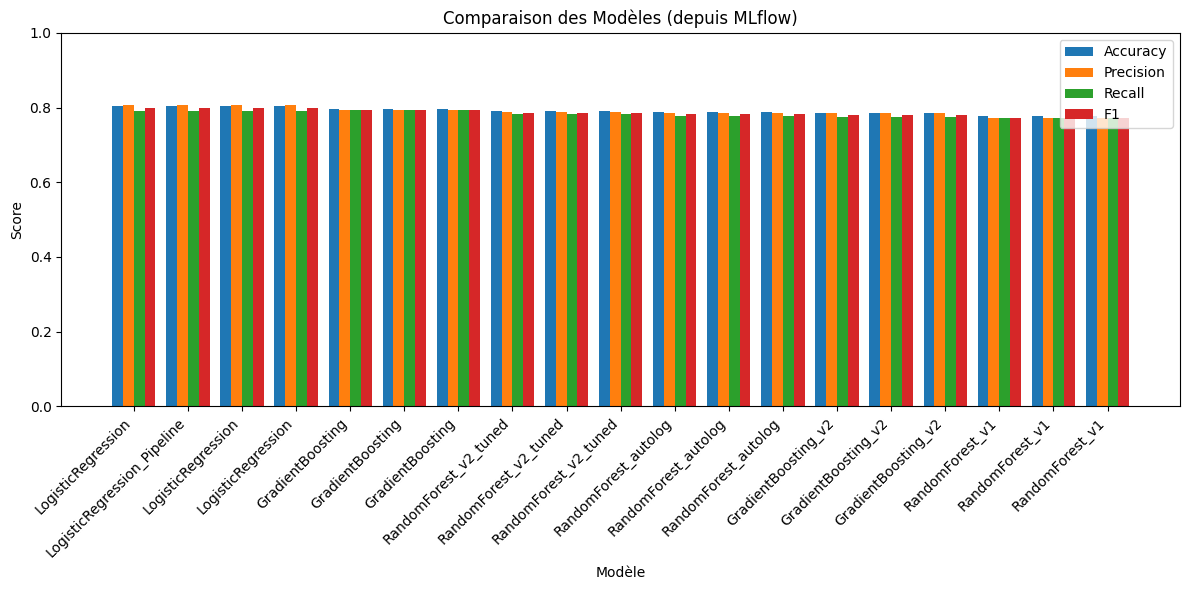

In [16]:
# Visualiser la comparaison
if len(results_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(results_df))
    width = 0.2
    
    ax.bar([i - 1.5*width for i in x], results_df['accuracy'], width, label='Accuracy')
    ax.bar([i - 0.5*width for i in x], results_df['precision'], width, label='Precision')
    ax.bar([i + 0.5*width for i in x], results_df['recall'], width, label='Recall')
    ax.bar([i + 1.5*width for i in x], results_df['f1'], width, label='F1')
    
    ax.set_xlabel('Modèle')
    ax.set_ylabel('Score')
    ax.set_title('Comparaison des Modèles (depuis MLflow)')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['run_name'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

In [17]:
# Trouver le meilleur modèle
if len(results_df) > 0:
    best_run = results_df.loc[results_df['f1'].idxmax()]
    print(f"Meilleur modèle par score F1 : {best_run['run_name']}")
    print(f"Score F1 : {best_run['f1']:.4f}")

Meilleur modèle par score F1 : LogisticRegression
Score F1 : 0.7992


## 7. Model Registry

Maintenant que nous avons trouvé notre meilleur modèle, **enregistrons-le**. Le Model Registry fournit :
- Contrôle de version pour les modèles
- Transitions d'état (Staging → Production)
- Lignage du modèle (quel run a créé ce modèle)

In [18]:
# Obtenir l'ID du meilleur run (par score F1)
best_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="metrics.f1 > 0",
    order_by=["metrics.f1 DESC"],
    max_results=1
)

if best_runs:
    best_run = best_runs[0]
    best_run_id = best_run.info.run_id
    print(f"Meilleur run : {best_run.info.run_name}")
    print(f"Run ID : {best_run_id}")
    print(f"F1 : {best_run.data.metrics.get('f1', 0):.4f}")

Meilleur run : LogisticRegression
Run ID : b08d207a765b47729c01e2db849cac42
F1 : 0.7992


In [19]:
# Enregistrer le meilleur modèle (même nom que dans 01b_mlflow_transition.ipynb)
model_name = "churn-predictor"

if best_runs:
    model_uri = f"runs:/{best_run_id}/model"
    
    # Enregistrer le modèle
    registered_model = mlflow.register_model(
        model_uri=model_uri,
        name=model_name
    )
    
    print(f"✅ Modèle enregistré : {model_name}")
    print(f"   Version : {registered_model.version}")
    print(f"\n📍 Voir dans l'UI : http://localhost:5000/#/models/{model_name}")
    print(f"\n💡 C'est le même nom que dans 01b - la correction de ce que vous avez fait !")

Registered model 'churn-predictor' already exists. Creating a new version of this model...
2026/02/24 21:34:47 WARNING mlflow.tracking._model_registry.fluent: Run with id b08d207a765b47729c01e2db849cac42 has no artifacts at artifact path 'model', registering model based on models:/m-369a63a346ee4ca98eeb09a7c2ae3203 instead
2026/02/24 21:34:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: churn-predictor, version 4


✅ Modèle enregistré : churn-predictor
   Version : 4

📍 Voir dans l'UI : http://localhost:5000/#/models/churn-predictor

💡 C'est le même nom que dans 01b - la correction de ce que vous avez fait !


Created version '4' of model 'churn-predictor'.


In [20]:
# Voir les versions du modèle enregistré
try:
    versions = client.search_model_versions(f"name='{model_name}'")
    print(f"\nVersions enregistrées de '{model_name}' :")
    print("=" * 60)
    for v in versions:
        print(f"Version {v.version} : Run ID {v.run_id[:8]}... | Statut : {v.status}")
except Exception as e:
    print(f"Aucun modèle enregistré trouvé : {e}")


Versions enregistrées de 'churn-predictor' :
Version 4 : Run ID b08d207a... | Statut : READY
Version 3 : Run ID 33d8ea14... | Statut : READY
Version 2 : Run ID 9ff4f785... | Statut : READY
Version 1 : Run ID e902d9f1... | Statut : READY


## 8. Charger et utiliser le modèle enregistré

En production, vous chargez les modèles depuis le registry - pas depuis des fichiers locaux !

In [21]:
# Charger le modèle depuis le registry avec les artefacts de prétraitement
import joblib
import tempfile

try:
    # Charger la dernière version
    model_uri = f"models:/{model_name}/latest"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    
    print(f"Modèle chargé : {model_name}")
    print(f"Type de modèle : {type(loaded_model).__name__}")
    
    # Vérifier si ce modèle nécessite un prétraitement
    client = MlflowClient()
    model_version = client.get_latest_versions(model_name, stages=[])[0]
    run_id = model_version.run_id
    run = client.get_run(run_id)
    
    requires_scaling = run.data.tags.get("requires_scaling", "false") == "true"
    
    if requires_scaling:
        print(f"\n⚠️  Ce modèle nécessite un prétraitement (scaling)")
        
        # Télécharger l'artefact du scaler
        artifact_path = client.download_artifacts(run_id, "preprocessing/scaler.pkl")
        scaler = joblib.load(artifact_path)
        print(f"✅ Scaler chargé depuis les artefacts")
        
        # Appliquer le prétraitement avant la prédiction
        X_test_scaled = scaler.transform(X_test[:5])
        sample_predictions = loaded_model.predict(X_test_scaled)
        sample_probas = loaded_model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nExemples de prédictions (avec prétraitement correct) :")
        for i, (pred, proba) in enumerate(zip(sample_predictions, sample_probas)):
            actual = y_test.iloc[i]
            print(f"  Client {i+1} : Prédit={pred}, Réel={actual}, Probabilité={proba:.2%}")
    else:
        # Les modèles basés sur les arbres n'ont pas besoin de scaling
        print(f"\n✅ Ce modèle n'a pas besoin de prétraitement")
        sample_predictions = loaded_model.predict(X_test[:5])
        sample_probas = loaded_model.predict_proba(X_test[:5])[:, 1]
        
        print("\nExemples de prédictions :")
        for i, (pred, proba) in enumerate(zip(sample_predictions, sample_probas)):
            actual = y_test.iloc[i]
            print(f"  Client {i+1} : Prédit={pred}, Réel={actual}, Probabilité={proba:.2%}")
        
except Exception as e:
    print(f"Impossible de charger depuis le registry : {e}")
    print("C'est attendu si c'est la première exécution.")

Modèle chargé : churn-predictor
Type de modèle : LogisticRegression

⚠️  Ce modèle nécessite un prétraitement (scaling)


✅ Scaler chargé depuis les artefacts

Exemples de prédictions (avec prétraitement correct) :
  Client 1 : Prédit=0, Réel=1, Probabilité=2.97%
  Client 2 : Prédit=1, Réel=0, Probabilité=75.17%
  Client 3 : Prédit=0, Réel=0, Probabilité=2.36%
  Client 4 : Prédit=1, Réel=1, Probabilité=97.34%
  Client 5 : Prédit=1, Réel=1, Probabilité=57.00%


### Point clé à retenir

Remarquez comment le code ci-dessus :
1. **Vérifie les tags du modèle** pour voir si un prétraitement est nécessaire
2. **Télécharge l'artefact du scaler** depuis MLflow
3. **Applique la même transformation** utilisée pendant l'entraînement

C'est le **pattern prêt pour la production** :
```python
# Pendant l'entraînement
scaler.fit_transform(X_train)  # Apprendre des données d'entraînement
mlflow.log_artifact("scaler.pkl")  # Le sauvegarder !

# Pendant l'inférence  
scaler = load_artifact("scaler.pkl")  # Le charger !
scaler.transform(X_new)  # Appliquer (ne jamais refaire fit !)
```

**Erreur courante :** Refaire fit du scaler sur de nouvelles données → échelle différente → prédictions incorrectes !

### ⭐ Meilleure pratique : sklearn Pipeline

L'approche ci-dessus (scaler.pkl séparé) fonctionne, mais elle a des risques :
- Oublier de charger le scaler à l'inférence
- Utiliser le mauvais scaler
- Gérer 2 artefacts au lieu d'un seul

**Solution recommandée : combiner scaler + modèle dans un sklearn Pipeline !**

```python
# Au lieu de :
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model.fit(X_scaled, y)
mlflow.log_artifact("scaler.pkl")  # Artefact 1
mlflow.log_model(model)            # Artefact 2

# Préférez :
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])
pipeline.fit(X, y)
mlflow.log_model(pipeline)         # UN SEUL artefact !
```

**Avantages :**
- Un seul artefact à gérer
- Impossible d'oublier le prétraitement
- Inférence ultra-simple : `pipeline.predict(X)`

In [22]:
# Exemple : Entraîner avec sklearn Pipeline (RECOMMANDÉ)
from sklearn.pipeline import Pipeline as SklearnPipeline

# Créer le pipeline : scaler + modèle en un seul objet
pipeline = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

with mlflow.start_run(run_name="LogisticRegression_Pipeline") as run:
    mlflow.set_tag("model_type", "LogisticRegression_Pipeline")
    mlflow.set_tag("pipeline_type", "sklearn_pipeline")
    mlflow.set_tag("author", "workshop")
    
    # Entraîner le pipeline complet (PAS DE SCALING MANUEL !)
    pipeline.fit(X_train, y_train)
    
    # Prédire (le pipeline applique automatiquement le scaling)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Métriques
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }
    mlflow.log_metrics(metrics)
    
    # Logger le pipeline comme modèle (inclut scaler + model !)
    mlflow.sklearn.log_model(pipeline, artifact_path="model")
    
    pipeline_run_id = run.info.run_id
    print(f"✅ Pipeline entraîné : Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}")
    print(f"✅ UN SEUL artefact loggé (scaler + model combinés)")
    print(f"\n💡 À l'inférence, il suffit de faire : pipeline.predict(X_new)")
    print(f"   Le scaling est automatique !")

2026/02/24 21:34:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/24 21:34:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✅ Pipeline entraîné : Accuracy=0.8050, F1=0.7992
✅ UN SEUL artefact loggé (scaler + model combinés)

💡 À l'inférence, il suffit de faire : pipeline.predict(X_new)
   Le scaling est automatique !
🏃 View run LogisticRegression_Pipeline at: http://localhost:5000/#/experiments/1/runs/a37d8078c7224d50a400703125e6f673
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [23]:
# Démonstration : Charger et utiliser le pipeline (SIMPLE !)
try:
    # Charger le pipeline depuis MLflow
    loaded_pipeline = mlflow.sklearn.load_model(f"runs:/{pipeline_run_id}/model")
    
    print("✅ Pipeline chargé depuis MLflow")
    print(f"   Type : {type(loaded_pipeline).__name__}")
    print(f"   Étapes : {[step[0] for step in loaded_pipeline.steps]}")
    
    # Prédire sur de nouvelles données - PAS DE SCALING MANUEL !
    X_new = X_test[:5]
    predictions = loaded_pipeline.predict(X_new)
    probas = loaded_pipeline.predict_proba(X_new)[:, 1]
    
    print("\n📊 Prédictions sur nouvelles données :")
    for i, (pred, proba, actual) in enumerate(zip(predictions, probas, y_test[:5])):
        status = "🔴 Churn" if pred == 1 else "🟢 Retain"
        print(f"   Client {i+1}: {status} (proba={proba:.2%}) | Réel={actual}")
    
    print("\n💡 Notez qu'on n'a PAS eu besoin de charger/appliquer le scaler !")
    print("   Le Pipeline fait TOUT automatiquement.")
    
except Exception as e:
    print(f"Erreur : {e}")

✅ Pipeline chargé depuis MLflow
   Type : Pipeline
   Étapes : ['scaler', 'model']

📊 Prédictions sur nouvelles données :
   Client 1: 🟢 Retain (proba=2.97%) | Réel=1
   Client 2: 🔴 Churn (proba=75.17%) | Réel=0
   Client 3: 🟢 Retain (proba=2.36%) | Réel=0
   Client 4: 🔴 Churn (proba=97.34%) | Réel=1
   Client 5: 🔴 Churn (proba=57.00%) | Réel=1

💡 Notez qu'on n'a PAS eu besoin de charger/appliquer le scaler !
   Le Pipeline fait TOUT automatiquement.


### Comparaison des approches

| Aspect | Approche Manuelle (scaler.pkl) | sklearn Pipeline (RECOMMANDÉ) |
|--------|-------------------------------|-------------------------------|
| **Artefacts** | 2 (model + scaler.pkl) | 1 (pipeline) |
| **Risque d'oubli** | Élevé (oublier le scaler) | Nul |
| **Code inférence** | Charger scaler → transform → predict | predict() directement |
| **Maintenance** | 2 objets à versionner | 1 objet |
| **Cas d'usage** | Pédagogique, comprendre le problème | **Production** |

**Recommandation :** Utilisez toujours sklearn Pipeline en production !

## 9. Serving du Modèle

Nous avons enregistré `churn-predictor` (le modèle simple, comme dans 01b). Maintenant, enregistrons et servons la **version améliorée** : le Pipeline sklearn.

### Pourquoi servir le Pipeline plutôt que le modèle simple ?

| Aspect | Modèle simple (`churn-predictor`) | Pipeline (`churn-predictor-pipeline`) |
|--------|-----------------------------------|---------------------------------------|
| **Prétraitement** | Nécessite scaler.pkl séparé | Intégré automatiquement |
| **Risque d'erreur** | Oublier de scaler les données | Impossible |
| **Code d'inférence** | Charger scaler + transformer + predict | Juste predict() |

### 9.1 Enregistrer le Pipeline dans le Registry

Enregistrons notre Pipeline (qui inclut le scaler) dans le Model Registry.

In [24]:
# Enregistrer le Pipeline dans le Model Registry
pipeline_model_name = "churn-predictor-pipeline"

model_uri = f"runs:/{pipeline_run_id}/model"
registered_pipeline = mlflow.register_model(model_uri, pipeline_model_name)

print(f"✅ Pipeline enregistré : {pipeline_model_name}")
print(f"   Version : {registered_pipeline.version}")
print(f"\n📍 Voir dans l'UI : http://localhost:5000/#/models/{pipeline_model_name}")

Registered model 'churn-predictor-pipeline' already exists. Creating a new version of this model...
2026/02/24 21:39:08 WARNING mlflow.tracking._model_registry.fluent: Run with id a37d8078c7224d50a400703125e6f673 has no artifacts at artifact path 'model', registering model based on models:/m-c9090888d50c474db53b04e264eb7bb4 instead
2026/02/24 21:39:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: churn-predictor-pipeline, version 2


✅ Pipeline enregistré : churn-predictor-pipeline
   Version : 2

📍 Voir dans l'UI : http://localhost:5000/#/models/churn-predictor-pipeline


Created version '2' of model 'churn-predictor-pipeline'.


### 9.2 Servir le modèle comme API REST

MLflow permet de servir n'importe quel modèle enregistré comme API REST en **une seule commande**.

> ⚠️ **Important** : La commande CLI `mlflow models serve` a besoin de savoir où trouver le serveur MLflow.
> Vous devez définir la variable d'environnement `MLFLOW_TRACKING_URI` !

**Commandes selon votre système :**

```bash
# Windows (PowerShell)
$env:MLFLOW_TRACKING_URI="http://localhost:5000"; mlflow models serve -m "models:/churn-predictor-pipeline/latest" -p 5001 --no-conda

# Windows (CMD)
set MLFLOW_TRACKING_URI=http://localhost:5000 && mlflow models serve -m "models:/churn-predictor-pipeline/latest" -p 5001 --no-conda

# Linux/Mac
MLFLOW_TRACKING_URI=http://localhost:5000 mlflow models serve -m "models:/churn-predictor-pipeline/latest" -p 5001 --no-conda
```

> ⚠️ **Si vous utilisez `uv` pour gérer votre environnement virtuel** et obtenez l'erreur "failed to canonicalize script path", utilisez :
> ```bash
> $env:MLFLOW_TRACKING_URI="http://localhost:5000"; uv run python -m mlflow models serve -m "models:/churn-predictor-pipeline/latest" -p 5001 --no-conda
> ```

**Explication des options :**
- `-m "models:/churn-predictor-pipeline/latest"` : Charger la dernière version du modèle depuis le Registry
- `-p 5001` : Servir sur le port 5001
- `--no-conda` : Ne pas créer d'environnement conda (utiliser l'environnement actuel)

In [25]:
# Vérifier que le modèle est bien enregistré et afficher la commande
import platform

try:
    versions = client.search_model_versions(f"name='{pipeline_model_name}'")
    if versions:
        print(f"✅ Modèle '{pipeline_model_name}' trouvé avec {len(versions)} version(s)")
        print(f"   Dernière version : {versions[0].version}")
        print(f"
" + "="*70)
        print("COMMANDE À EXÉCUTER DANS UN TERMINAL :")
        print("="*70)
        
        if platform.system() == "Windows":
            print(f'
# PowerShell:')
            print(f'$env:MLFLOW_TRACKING_URI="http://localhost:5000"; mlflow models serve -m "models:/{pipeline_model_name}/latest" -p 5001 --no-conda')
            print(f'
# CMD:')
            print(f'set MLFLOW_TRACKING_URI=http://localhost:5000 && mlflow models serve -m "models:/{pipeline_model_name}/latest" -p 5001 --no-conda')
            print(f'
# Si erreur "failed to canonicalize script path" (avec uv):')
            print(f'$env:MLFLOW_TRACKING_URI="http://localhost:5000"; uv run python -m mlflow models serve -m "models:/{pipeline_model_name}/latest" -p 5001 --no-conda')
        else:
            print(f'
MLFLOW_TRACKING_URI=http://localhost:5000 mlflow models serve -m "models:/{pipeline_model_name}/latest" -p 5001 --no-conda')
        
        print(f"
" + "="*70)
    else:
        print(f"❌ Modèle '{pipeline_model_name}' non trouvé")
        print("   → Exécutez d'abord la cellule d'enregistrement ci-dessus !")
except Exception as e:
    print(f"❌ Erreur : {e}")

✅ Modèle 'churn-predictor-pipeline' trouvé avec 2 version(s)
   Dernière version : 2

COMMANDE À EXÉCUTER DANS UN TERMINAL :

# PowerShell:
$env:MLFLOW_TRACKING_URI="http://localhost:5000"; mlflow models serve -m "models:/churn-predictor-pipeline/latest" -p 5001 --no-conda

# CMD:
set MLFLOW_TRACKING_URI=http://localhost:5000 && mlflow models serve -m "models:/churn-predictor-pipeline/latest" -p 5001 --no-conda



### 9.3 Tester l'API REST

Une fois le serveur lancé (dans un autre terminal), vous pouvez tester l'API avec des requêtes HTTP.

**Format de l'API MLflow :**
- Endpoint : `POST http://localhost:5001/invocations`
- Content-Type : `application/json`
- Body : `{"dataframe_split": {"columns": [...], "data": [[...], [...]]}}` ou `{"dataframe_records": [{...}, {...}]}`

In [26]:
# Tester l'API REST (décommentez quand le serveur tourne)
import requests
import json

# Préparer des données de test
sample_customers = X_test.head(5)
payload = {
    "dataframe_split": sample_customers.to_dict(orient='split')
}

# Vérifier si le serveur est accessible
serve_url = "http://localhost:5001/invocations"

try:
    response = requests.post(
        serve_url,
        headers={"Content-Type": "application/json"},
        json=payload,
        timeout=5
    )
    
    if response.status_code == 200:
        predictions = response.json()
        print("✅ Réponse de l'API MLflow :")
        print(f"   Prédictions : {predictions['predictions']}")
        
        print("\n📊 Détails des prédictions :")
        for i, (pred, actual) in enumerate(zip(predictions['predictions'], y_test.head(5))):
            status = "🔴 Churn" if pred == 1 else "🟢 Retain"
            match = "✓" if pred == actual else "✗"
            print(f"   Client {i+1}: {status} | Réel: {actual} {match}")
    else:
        print(f"❌ Erreur API : {response.status_code}")
        print(f"   {response.text}")
        
except requests.exceptions.ConnectionError:
    print("⚠️  Le serveur MLflow n'est pas accessible sur le port 5001")
    print("\n   Pour le démarrer, exécutez la commande affichée dans la cellule précédente")
    print("   puis réexécutez cette cellule.")
    
except Exception as e:
    print(f"❌ Erreur : {e}")

✅ Réponse de l'API MLflow :
   Prédictions : [0, 0, 0, 0, 0]

📊 Détails des prédictions :
   Client 1: 🟢 Retain | Réel: 1 ✗
   Client 2: 🟢 Retain | Réel: 0 ✓
   Client 3: 🟢 Retain | Réel: 0 ✓
   Client 4: 🟢 Retain | Réel: 1 ✗
   Client 5: 🟢 Retain | Réel: 1 ✗


### 9.4 Inférence Batch (Alternative au serving REST)

Pour des prédictions en masse (ex: scoring quotidien de tous les clients), l'API REST n'est pas optimale.
Préférez charger le modèle directement et prédire en batch.

In [27]:
# Inférence batch - c'est ce que les orchestrateurs font !
import time

# Charger le modèle depuis le Registry
print("Chargement du modèle depuis le Registry...")
start = time.time()
batch_model = mlflow.sklearn.load_model(f"models:/{pipeline_model_name}/latest")
load_time = time.time() - start
print(f"✅ Modèle chargé en {load_time:.2f}s")

# Simuler un batch de nouveaux clients (toutes les données)
print(f"\nScoring de {len(X)} clients...")
start = time.time()
all_predictions = batch_model.predict(X)
all_probas = batch_model.predict_proba(X)[:, 1]
predict_time = time.time() - start
print(f"✅ Prédictions terminées en {predict_time:.2f}s")

# Créer le rapport de résultats
results_df = pd.DataFrame({
    'customer_id': df['customer_id'],
    'churn_probability': all_probas,
    'churn_predicted': all_predictions,
    'churn_actual': df['churned']
})

# Statistiques
n_churn_predicted = (all_predictions == 1).sum()
n_churn_actual = (df['churned'] == 1).sum()
accuracy = (all_predictions == df['churned']).mean()

print(f"\n📊 Résultats du scoring batch :")
print(f"   Clients à risque (prédits) : {n_churn_predicted} ({n_churn_predicted/len(X):.1%})")
print(f"   Clients churned (réels) : {n_churn_actual} ({n_churn_actual/len(X):.1%})")
print(f"   Accuracy globale : {accuracy:.2%}")

# Afficher les clients les plus à risque
print(f"\n🔴 Top 10 clients les plus à risque :")
top_risk = results_df.nlargest(10, 'churn_probability')[['customer_id', 'churn_probability', 'churn_actual']]
print(top_risk.to_string(index=False))

Chargement du modèle depuis le Registry...


✅ Modèle chargé en 0.75s

Scoring de 5000 clients...
✅ Prédictions terminées en 0.01s

📊 Résultats du scoring batch :
   Clients à risque (prédits) : 2403 (48.1%)
   Clients churned (réels) : 2452 (49.0%)
   Accuracy globale : 78.82%

🔴 Top 10 clients les plus à risque :
 customer_id  churn_probability  churn_actual
        2900           0.999017             1
        3320           0.998706             1
        3067           0.997959             1
        4587           0.997767             1
        3453           0.997323             1
        1000           0.997170             1
        2546           0.996244             1
        4643           0.995887             1
        3900           0.995591             1
        1493           0.995388             1


### 9.5 Comparaison : API REST vs Batch

| Aspect | API REST (`mlflow models serve`) | Batch (`load_model` + `predict`) |
|--------|----------------------------------|----------------------------------|
| **Cas d'usage** | Prédictions temps réel, une à la fois | Scoring de masse, pipelines |
| **Latence** | ~10-100ms par requête | Quelques secondes pour des milliers |
| **Scalabilité** | Limité par le serveur | Parallélisable (Spark, Dask) |
| **Infrastructure** | Serveur web à maintenir | Aucune (script batch) |
| **Intégration** | API standard (HTTP/JSON) | Code Python directement |

**Recommandations :**
- **API REST** : Applications web, apps mobiles, intégrations tierces
- **Batch** : Scoring quotidien, pipelines ML, data engineering

**Les orchestrateurs (Prefect, Dagster, Airflow) utilisent l'approche batch** pour automatiser le scoring !

### 9.6 Résumé : Les deux modèles enregistrés

Vous avez maintenant **deux modèles** dans le Registry :

| Modèle | Usage | Commande de serving |
|--------|-------|---------------------|
| `churn-predictor` | Correction de 01b (simple) | `mlflow models serve -m "models:/churn-predictor/latest" -p 5001 --no-conda` |
| `churn-predictor-pipeline` | **Production (recommandé)** | `mlflow models serve -m "models:/churn-predictor-pipeline/latest" -p 5001 --no-conda` |

> ⚠️ **N'oubliez pas** : Définissez `MLFLOW_TRACKING_URI=http://localhost:5000` avant de lancer la commande !

> 💡 **Recommandation** : Utilisez toujours la version Pipeline en production !

## 10. Voir l'UI MLflow

Le serveur MLflow tourne dans Docker. Ouvrez http://localhost:5000 dans votre navigateur.

Vous verrez :
- Toutes les expériences et runs
- Comparaison de paramètres et métriques
- Navigateur d'artefacts (modèles, graphiques)
- Model registry

**Note :** Si vous n'avez pas encore démarré le serveur, exécutez :
```bash
docker-compose up -d
```

---

## Résumé : Ce que MLflow a résolu

| Problème (Notebook chaotique) | Solution (MLflow) |
|-------------------------------|-------------------|
| "C'était lequel le meilleur modèle ?" | Requêter les runs par métriques |
| Métriques éparpillées dans les cellules | Stockage centralisé des métriques |
| Pas de versioning | Model Registry avec versions |
| Impossible de reproduire | Run ID lié au code/params exact |
| Comparaison manuelle | UI de comparaison automatique |
| Fichiers de modèles perdus | Artefacts stockés avec le run |
| Servir le modèle manuellement | `mlflow models serve` en une commande |
| Inférence batch complexe | `load_model` + `predict` directement |

## Ce qui reste manuel ?

MLflow ne résout pas tout :
- **Planification** : Comment exécuter ça quotidiennement ?
- **Dépendances** : Et si le chargement des données échoue ?
- **Alertes** : Comment savoir si l'entraînement a échoué ?
- **CI/CD** : Comment automatiser le déploiement ?

**Prochaine étape** : Orchestrateurs (Prefect, Airflow, Dagster) pour automatiser le pipeline !

---